In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import random
from tqdm.notebook import tqdm 
import IPython.display as ipd
import matplotlib.pyplot as plt
import gc 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Model
from sklearn.model_selection import train_test_split


In [ ]:
TARGET_SR = 16000
DURATION = 3 
SAMPLES_PER_TRACK = TARGET_SR * DURATION

def process_audio_chunk(file_path):
    """
    Loads audio, ensures it is mono, resamples, and pads/crops to fixed length.
    """
    try:
        y, sr = librosa.load(file_path, sr=TARGET_SR, mono=True)
        
        y, _ = librosa.effects.trim(y)
        
        if len(y) > SAMPLES_PER_TRACK:
            max_start = len(y) - SAMPLES_PER_TRACK
            start = random.randint(0, max_start)
            y = y[start : start + SAMPLES_PER_TRACK]
        else:
            padding = SAMPLES_PER_TRACK - len(y)
            y = np.pad(y, (0, padding), 'constant')
            
        if np.max(np.abs(y)) > 0:
            y = y / np.max(np.abs(y))
            
        return y
    except Exception as e:
        return None

In [ ]:
def process_ravdess(base_path):
    data = []
    print("Processing RAVDESS...")
    
    for dirname, _, filenames in os.walk(base_path):
        for filename in filenames:
            if filename.endswith('.wav'):
                parts = filename.split('-')
                emotion = int(parts[2])
                
                if emotion in [4, 6]:
                    path = os.path.join(dirname, filename)
                    audio = process_audio_chunk(path)
                    
                    if audio is not None:
                        score = np.random.uniform(0.0, 0.3)
                        data.append({"audio": audio, "score": score, "source": "RAVDESS"})
                        
    return pd.DataFrame(data)

ravdess_path = '/kaggle/input/ravdess-emotional-speech-audio'
df_ravdess = process_ravdess(ravdess_path)
print(f"RAVDESS samples: {len(df_ravdess)}")

Processing RAVDESS...
RAVDESS samples: 768


In [4]:
df_ravdess.head()

,audio,score,source
0,"[1.46295615e-05, -0.0001234224, 1.2375074e-05,...",0.119102,RAVDESS
1,"[3.2909622e-06, -1.27806625e-05, 1.5434736e-05...",0.165393,RAVDESS
2,"[0.00013632906, 5.615602e-05, 0.00022361685, 0...",0.030451,RAVDESS
3,"[-0.00015536726, -8.3345505e-05, -2.2884029e-0...",0.245599,RAVDESS
4,"[-3.595926e-05, 0.00022389322, 0.00035758165, ...",0.169198,RAVDESS


In [ ]:
TARGET_SR = 16000
DURATION = 3 
HESITATION_TARGETS = ['um', 'uh', 'uh-huh', 'um-hum', 'ah', '<sil>', '{sil}'] 

def get_audio_window(y, sr, center_time, window_duration):
    """ Extracts 3s window centered on the timestamp """
    center_sample = int(center_time * sr)
    half_window = int((window_duration * sr) / 2)
    start = center_sample - half_window
    end = center_sample + half_window
    
    pad_left = 0
    pad_right = 0
    
    if start < 0:
        pad_left = abs(start)
        start = 0
    if end > len(y):
        pad_right = end - len(y)
        end = len(y)
        
    chunk = y[start:end]
    
    if pad_left > 0 or pad_right > 0:
        chunk = np.pad(chunk, (pad_left, pad_right), 'constant')
        
    return chunk

def process_buckeye_fixed(base_path, limit=1000):
    data = []
    print(f"Scanning {base_path}...")
    
    for root, dirs, files in os.walk(base_path):
        if len(data) >= limit: break
        
        word_files = [f for f in files if f.endswith('.words')]
        
        for w_filename in word_files:
            if len(data) >= limit: break
            
            base_id = w_filename.replace('.words', '')
            audio_filename = base_id + ".wav"
            
            if audio_filename in files:
                wav_path = os.path.join(root, audio_filename)
                word_path = os.path.join(root, w_filename)
                
                try:
                    df_words = pd.read_csv(word_path, sep='\s+', 
                                         names=['time', 'color', 'word'], 
                                         usecols=[0, 1, 2], 
                                         skiprows=9, 
                                         header=None, 
                                         on_bad_lines='skip')
                    
                    df_words['word'] = df_words['word'].astype(str).str.replace(';', '').str.lower()
                    
                    hesitations = df_words[df_words['word'].isin(HESITATION_TARGETS)]
                    
                    if hesitations.empty:
                        continue

                    y_full, sr = librosa.load(wav_path, sr=TARGET_SR, mono=True)
                    
                    for _, row in hesitations.iterrows():
                        if len(data) >= limit: break
                        
                        timestamp = float(row['time']) + 0.2
                        
                        chunk = get_audio_window(y_full, sr, timestamp, DURATION)
                        
                        if np.max(np.abs(chunk)) > 0:
                            chunk = chunk / np.max(np.abs(chunk))
                            
                        score = np.random.uniform(0.2, 0.5)
                        
                        data.append({
                            "audio": chunk, 
                            "score": score, 
                            "source": "Buckeye",
                            "word": row['word']
                        })
                        
                except Exception as e:
                    continue

    return pd.DataFrame(data)

buckeye_path = '/kaggle/input/buckeye-corpus'
df_buckeye = process_buckeye_fixed(buckeye_path, limit=2000)

print(f"Success! Extracted {len(df_buckeye)} hesitation clips.")
print(df_buckeye.head())

Scanning /kaggle/input/buckeye-corpus...
Success! Extracted 2000 hesitation clips.
                                               audio     score   source  \
0  [-0.00990099, -0.01430143, -0.01870187, -0.019...  0.402669  Buckeye   
1  [0.028543307, 0.027559055, 0.021653544, 0.0236...  0.435495  Buckeye   
2  [-0.27200097, -0.2814429, -0.20772304, -0.1991...  0.405595  Buckeye   
3  [-0.06439971, -0.063517526, -0.050445102, -0.0...  0.235584  Buckeye   
4  [-0.14844815, -0.29657552, -0.35848907, -0.336...  0.302776  Buckeye   

     word  
0      ah  
1  um-hum  
2   <sil>  
3   <sil>  
4      uh  


--- SAMPLE DETAILS ---
Source: Buckeye
Target Word: '<sil>'
Assigned Confidence Score: 0.2055
Shape: (48000,)


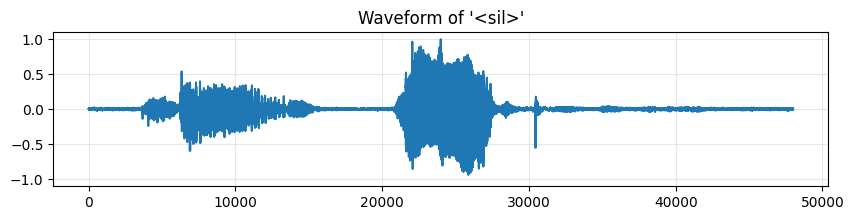

In [ ]:
row = df_buckeye.sample(1).iloc[0]

audio_data = row['audio']
word_label = row.get('word', 'N/A') 
score = row['score']

print(f"--- SAMPLE DETAILS ---")
print(f"Source: {row['source']}")
print(f"Target Word: '{word_label}'")
print(f"Assigned Confidence Score: {score:.4f}")
print(f"Shape: {audio_data.shape}")

plt.figure(figsize=(10, 2))
plt.plot(audio_data)
plt.title(f"Waveform of '{word_label}'")
plt.ylim(-1.1, 1.1)
plt.grid(True, alpha=0.3)
plt.show()

ipd.Audio(audio_data, rate=16000)

In [ ]:
TARGET_SR = 16000
DURATION = 3 
SAMPLES_PER_TRACK = TARGET_SR * DURATION

def process_audio_chunk(file_path):
    """
    Loads audio and takes a random 3-second crop.
    """
    try:
        y, sr = librosa.load(file_path, sr=TARGET_SR, mono=True)
        
        y, _ = librosa.effects.trim(y)
        
        if len(y) > SAMPLES_PER_TRACK:
            max_start = len(y) - SAMPLES_PER_TRACK
            start = random.randint(0, max_start)
            y = y[start : start + SAMPLES_PER_TRACK]
        else:
            padding = SAMPLES_PER_TRACK - len(y)
            y = np.pad(y, (0, padding), 'constant')
            
        max_val = np.max(np.abs(y))
        if max_val > 0:
            y = y / max_val
            
        return y
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def process_librispeech_deep(base_path, limit=2000):
    data = []
    print(f"Scanning {base_path}...")
    
    for root, dirs, files in os.walk(base_path):
        if len(data) >= limit: break
        
        audio_files = [f for f in files if f.endswith('.flac') or f.endswith('.wav')]
        
        for file in audio_files:
            if len(data) >= limit: break
            
            file_path = os.path.join(root, file)
            
            processed_audio = process_audio_chunk(file_path)
            
            if processed_audio is not None:
                score = np.random.uniform(0.7, 1.0)
                
                data.append({
                    "audio": processed_audio,
                    "score": score,
                    "source": "LibriSpeech",
                    "file_id": file
                })

    return pd.DataFrame(data)

libri_path = '/kaggle/input/librispeech/LibriSpeech/dev-clean' 

if os.path.exists(libri_path):
    df_libri = process_librispeech_deep(libri_path, limit=2000)
    print(f"Success! Processed {len(df_libri)} LibriSpeech samples.")
else:
    print(f"Error: Path not found: {libri_path}")
    print("Please check the 'Input' section in Kaggle sidebar and copy the path to 'dev-clean'.")

Scanning /kaggle/input/librispeech/LibriSpeech/dev-clean...
Success! Processed 2000 LibriSpeech samples.


In [ ]:
if 'audio_array' in df_ravdess.columns:
    df_ravdess = df_ravdess.rename(columns={'audio_array': 'audio', 'label': 'score'})

df_ravdess = df_ravdess[['audio', 'score']]
df_buckeye = df_buckeye[['audio', 'score']]
df_libri = df_libri[['audio', 'score']]

print("Merging datasets...")
final_df = pd.concat([df_ravdess, df_buckeye, df_libri], ignore_index=True)

final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Total Samples: {len(final_df)}")

del df_ravdess
del df_buckeye
del df_libri
gc.collect() 

X = np.stack(final_df['audio'].values)
y = final_df['score'].values.astype('float32')

print(f"X Shape: {X.shape}") 
print(f"y Shape: {y.shape}") 

np.save('/kaggle/working/X_train.npy', X)
np.save('/kaggle/working/y_train.npy', y)

print("✅ Data saved to /kaggle/working/. You are ready for Model Training.")

Merging datasets...
Total Samples: 4768
X Shape: (4768, 48000)
y Shape: (4768,)
✅ Data saved to /kaggle/working/. You are ready for Model Training.


In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

2025-11-26 12:10:00.330499: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764159000.646390      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764159000.695027      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Using device: cuda


In [ ]:
class ConfidenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        audio = torch.tensor(self.X[idx], dtype=torch.float32)
        score = torch.tensor(self.y[idx], dtype=torch.float32)
        return audio, score

print("Loading data...")
X = np.load('/kaggle/working/X_train.npy')
y = np.load('/kaggle/working/y_train.npy')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = ConfidenceDataset(X_train, y_train)
test_dataset = ConfidenceDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f"Training on {len(X_train)} samples, Validating on {len(X_test)} samples.")

Loading data...
Training on 3814 samples, Validating on 954 samples.


In [ ]:
class Wav2Vec2ForConfidence(nn.Module):
    def __init__(self, pretrained_model_name="facebook/wav2vec2-base"):
        super(Wav2Vec2ForConfidence, self).__init__()
        
        self.wav2vec2 = Wav2Vec2Model.from_pretrained(pretrained_model_name)
        
        self.wav2vec2.feature_extractor.requires_grad_(False)
        
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, 1) 
        self.sigmoid = nn.Sigmoid() 
        
    def forward(self, input_values):
        outputs = self.wav2vec2(input_values)
        
        hidden_states = outputs.last_hidden_state
    
        pooled_output = torch.mean(hidden_states, dim=1)
        
        x = self.dropout(pooled_output)
        x = self.classifier(x)
        x = self.sigmoid(x)
        
        return x.squeeze() 

model = Wav2Vec2ForConfidence().to(device)
print("Model initialized.")

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:309: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Model initialized.


In [ ]:
EPOCHS = 3 
LEARNING_RATE = 1e-5 
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    
    loop = tqdm(train_loader, leave=True)
    
    for batch_idx, (audio, score) in enumerate(loop):
        audio = audio.to(device)
        score = score.to(device)
        
        predictions = model(audio)
        loss = criterion(predictions, score)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}]")
        loop.set_postfix(loss=loss.item())
        
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for audio, score in test_loader:
            audio = audio.to(device)
            score = score.to(device)
            preds = model(audio)
            val_loss += criterion(preds, score).item()
            
    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)
    
    print(f"End of Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

print("Training Complete!")

  0%|          | 0/477 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

End of Epoch 1 | Train Loss: 0.0166 | Val Loss: 0.0084


  0%|          | 0/477 [00:00<?, ?it/s]

End of Epoch 2 | Train Loss: 0.0078 | Val Loss: 0.0093


  0%|          | 0/477 [00:00<?, ?it/s]

End of Epoch 3 | Train Loss: 0.0076 | Val Loss: 0.0084
Training Complete!


In [ ]:
index = 10 
test_audio, true_score = test_dataset[index]

input_tensor = test_audio.unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    predicted_score = model(input_tensor).item()

print("--- PREDICTION RESULT ---")
print(f"True Label: {true_score.item():.4f}")
print(f"Model Prediction: {predicted_score:.4f}")
print(f"Difference: {abs(true_score.item() - predicted_score):.4f}")

if predicted_score > 0.7:
    print("Verdict: High Confidence")
elif predicted_score < 0.35:
    print("Verdict: Low Confidence")
else:
    print("Verdict: Uncertain / Neutral")

--- PREDICTION RESULT ---
True Label: 0.8613
Model Prediction: 0.8947
Difference: 0.0334
Verdict: High Confidence


In [14]:
torch.save(model.state_dict(), 'confidence_model.pth')
print("Model saved as confidence_model.pth")

Model saved as confidence_model.pth


In [ ]:
TEST_FILE_NAME = "Recording (6).wav" 

def predict_confidence(filename, model, device):
    path = f"/kaggle/input/test-voice/{filename}"
    
    try:
        y, sr = librosa.load(path, sr=16000, mono=True)
    except Exception as e:
        print(f"❌ Error loading file: {e}")
        print("Did you upload it to /kaggle/working/?")
        return

    target_length = 48000 
    
    if len(y) > target_length:
        num_chunks = len(y) // target_length
        chunks = [y[i*target_length : (i+1)*target_length] for i in range(num_chunks)]
    else:
        padding = target_length - len(y)
        chunks = [np.pad(y, (0, padding), 'constant')]

    model.eval() 
    scores = []
    
    print(f"🎧 Analyzing: {filename}")
    print(f"⏱️ Duration: {len(y)/16000:.2f} seconds")
    print("-" * 30)

    for i, chunk in enumerate(chunks):
        if np.max(np.abs(chunk)) > 0:
            chunk = chunk / np.max(np.abs(chunk))
            
        input_tensor = torch.tensor(chunk, dtype=torch.float32).unsqueeze(0).to(device)
        
        with torch.no_grad():
            prediction = model(input_tensor).item()
            scores.append(prediction)
            print(f"   Chunk {i+1}: {prediction:.4f}")

    final_score = sum(scores) / len(scores)
    
    print("-" * 30)
    print(f"⭐️ FINAL CONFIDENCE SCORE: {final_score:.4f}")
    
    if final_score > 0.6:
        print("✅ Verdict: HIGH CONFIDENCE")
    elif final_score > 0.4 or final_score < 0.6:
        print("⚖️ Verdict: NEUTRAL / UNCERTAIN")
    else:
        print("⚠️ Verdict: LOW CONFIDENCE")
        
    return ipd.Audio(path)

predict_confidence(TEST_FILE_NAME, model, device)

/tmp/ipykernel_47/1505519426.py:17: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=16000, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


🎧 Analyzing: Recording (6).wav
⏱️ Duration: 21.76 seconds
------------------------------
   Chunk 1: 0.3130
   Chunk 2: 0.3671
   Chunk 3: 0.2956
   Chunk 4: 0.3749
   Chunk 5: 0.3217
   Chunk 6: 0.3717
   Chunk 7: 0.7810
------------------------------
⭐️ FINAL CONFIDENCE SCORE: 0.4036
⚖️ Verdict: NEUTRAL / UNCERTAIN
